In [2]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cse455/assignments/assignment3/'
FOLDERNAME = 'cse455/assignments/assignment3_colab/assignment3_colab/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/cse455/assignments/assignment3_colab/assignment3_colab


# Cameras

So far, we've looked at a ton of neat things that we can do with images: filtering, edge detection, stitching, segmentation, and resizing. Look at how far we've come!

In this part of the assignment, we'll explore some of the geometry that underlies how these images are formed.

In [3]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


def hash_numpy(x):
    import hashlib

    return hashlib.sha1(x.view(np.uint8)).hexdigest()


%load_ext autoreload
%autoreload 2

## 1. Transformations in 3D

In order to make sense of how objects in our world are rendered in a camera, we typically need to understand how they are located relative to the camera. In this question, we'll examine some properties of the transformations that formalize this process by expressing coordinates with respect to multiple frames.

We'll be considering a scene with two frames: a world frame ($W$) and a camera frame ($C$).

Notice that:
- We have 3D points $p$, $q$, $r$, and $s$ that define a square, which is parallel to the world $zy$ plane
- $C_z$ and $C_x$ belong to the plane defined by $W_z$ and $W_x$
- $C_y$ is parallel to $W_y$

<!-- into camera space as we translate a simple shape from world coordinates to camera coordinates. We will take this square in world coordinates and transform it into the camera coordinates.-->

<img src="https://drive.google.com/uc?export=view&id=102Bg6glKMWrglWyVSF_Wazm5MnSVHX_P" alt="projection geometry figure" width="640" />

### 1.1 Reference Frame Definitions

First, we'll take a moment to validate your understanding of 3D reference frames.

Consider creating:
- A point $w$ at the origin of the world frame ($O_w$)
- A point $c$ at the origin of the camera frame ($O_c$)

Examine the $x$, $y$, and $z$ axes of each frame, then express these points with respect to the world and camera frames. Fill in **`w_wrt_camera`**, **`w_wrt_world`**, and **`c_wrt_camera`**.

You can consider the length $d = 1$.

In [4]:
d = 1.0

# Abbreviation note:
# - "wrt" stands for "with respect to", which is ~synonymous with "relative to"

w_wrt_world = np.array([0.0, 0.0, 0.0])  # Done for you
w_wrt_camera = None  # Assign me!

c_wrt_world = None  # Assign me!
c_wrt_camera = None  # Assign me!

### YOUR CODE HERE
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

w_wrt_camera = np.array([0, 0, d])
c_wrt_world = np.array([d/np.sqrt(2), 0, d/np.sqrt(2)])
c_wrt_camera = np.array([0, 0, 0])


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
### END YOUR CODE

In [5]:
# Run this cell to check your answers!
assert (
    (3,)
    == w_wrt_world.shape
    == w_wrt_camera.shape
    == c_wrt_world.shape
    == c_wrt_camera.shape
), "Wrong shape!"
assert (
    hash_numpy(w_wrt_world) == "d3399b7262fb56cb9ed053d68db9291c410839c4"
), "Double check your w_wrt_world!"
assert (
    hash_numpy(w_wrt_camera) == "6248a1dcfe0c8822ba52527f68f7f98955584277"
), "Double check your w_wrt_camera!"
assert (
    hash_numpy(c_wrt_camera) == "d3399b7262fb56cb9ed053d68db9291c410839c4"
), "Double check your c_wrt_camera!"
assert (
    hash_numpy(c_wrt_world) == "a4c525cd853a072d96cade8b989a9eaf1e13ed3d"
), "Double check your c_wrt_world!"

print("Looks correct!")

Looks correct!


### 1.2 World ⇨ Camera Transforms

Derive the homogeneous transformation matrix needed to convert a point expressed with respect to the world frame $W$ in the camera frame $C$.

**Discuss the rotation and translation terms in this matrix and how you determined them, then implement it in `camera_from_world_transform()`**.

We've also supplied a set of `assert` statements below to help you check your work.

---

*Hint #1:*
With rotation matrix $R \in \mathbb{R}^{3\times 3}$ and translation vector $t \in \mathbb{R}^{3\times 1}$, you can write transformations as $4 \times 4$ matrices:
$$
\begin{bmatrix}{x_C} \\ {y_C} \\ {z_C} \\ 1\end{bmatrix} =
\begin{bmatrix}
    R & t \\
    \vec{0}^\top & 1
\end{bmatrix}
\begin{bmatrix}{x_W} \\ {y_W} \\ {z_W} \\ 1\end{bmatrix}
$$

*Hint #2: Remember our 2D transformation matrix for rotations in the $xy$ plane.*

$$\begin{bmatrix}{x}' \\ {y}'\end{bmatrix} = \begin{bmatrix} \cos(\theta) & -\sin(\theta) \\ \sin(\theta) & \cos(\theta)\end{bmatrix} \begin{bmatrix}{x} \\ {y}\end{bmatrix}$$

To apply this to 3D rotations, you might think of this $xy$ plane rotation as holding the $z$ coordinate constant, since that's the axis you're rotating around, and transforming the $x$ and $y$ coordinates as described in the 2D formulation:

$$\begin{bmatrix}{x}' \\ {y}' \\ {z}'\end{bmatrix}  = \begin{bmatrix} \cos(\theta) & -\sin(\theta) & 0 \\ \sin(\theta) & \cos(\theta) & 0 \\ 0 & 0 & 1\end{bmatrix} \begin{bmatrix}{x} \\ {y} \\ {z}\end{bmatrix}$$

(the [Wikipedia](https://en.wikipedia.org/wiki/Rotation_matrix) page may also be helpful)

*Hint #3: In a homogeneous transform, the translation is applied after the rotation.*

As a result, you can visualize the translation as an offset in the output frame.

The order matters! You'll end up with a different transformation if you translate and then rotate versus if you rotate first and then translate with the same offsets. In lecture 2 we discussed a formulation for a combinated scaling, rotating, and translating matrix (in that order), which can be a useful starting point.

---

**Your response here:** Write your answer in this markdown cell.

From the diagram, we can see the vector from $O_W$ to $O_C$ lies in the plane defined by $w_x$ and $w_z$. The distance from $O_W$ to $O_C$ is given as $d$ and its components along $w_x$ and $w_z$ are both $\frac{d}{\sqrt{2}}$. This symmetry indicates that the vector from $O_W$ to $O_C$ forms a 45° angle with both the positive $w_x$ axis and the negative $w_z$ axis.

Starting at the positive $w_x$ axis and rotating toward the negative $w_z$ requires a rotation of: 90° (from positive $w_x$ axis to negative $w_z$ axis) plus an additional 45° to align with the diagonal vector pointing toward $O_c$.

Thus, the total rotation angle is: 135° or $\frac{3π}{4}$ clockwise.

From the wikipedia page, we can also see the rotation matrix is:
$$R'=\begin{bmatrix} \cos(\theta) & 0 & \sin(\theta) \\ 0 & 1 & 0 \\ -\sin(\theta) & 0 & \cos(\theta) \end{bmatrix}$$

We know the translation matrix will be given by transforming $O_w$ (a point in the world) with respect to the camera. This we derived in question 1.1, which can represented as the following: $$t'= \begin{bmatrix} 0 \\ 0 \\ d \end{bmatrix}$$

In totality:
$$
T =
\begin{bmatrix}
    R' & t' \\
    \vec{0}^\top & 1
\end{bmatrix}
$$

In [6]:
# Check your answer against 1.1!
from cameras import camera_from_world_transform

T_camera_from_world = camera_from_world_transform()

# Check c_wrt_camera against T_camera_from_world @ w_wrt_world
w_wrt_camera_computed = (T_camera_from_world @ np.append(w_wrt_world, 1.0))[:3]
print(f"w_wrt camera: expected {w_wrt_camera}, computed {w_wrt_camera_computed}")
assert np.allclose(
    w_wrt_camera, w_wrt_camera_computed
), "Error! (likely bad translation)"
print("Translation components look reasonable!")

# Check w_wrt_camera against T_camera_from_world @ c_wrt_world
c_wrt_camera_computed = (T_camera_from_world @ np.append(c_wrt_world, 1.0))[:3]
print(f"c_wrt camera: expected {c_wrt_camera}, computed {c_wrt_camera_computed}")
assert np.allclose(
    c_wrt_camera, c_wrt_camera_computed
), "Error! (likely bad rotation)"
print("Rotation components looks reasonable!")

w_wrt camera: expected [0. 0. 1.], computed [0. 0. 1.]
Translation components look reasonable!
c_wrt camera: expected [0 0 0], computed [1.11022302e-16 0.00000000e+00 1.11022302e-16]
Rotation components looks reasonable!


### 1.3 Preserving Edge Orientations (Geometric Intuition)

Under the translation and rotation transformation from world coordinates to camera coordinates, which, if any, of the edges of the square retain their orientation and why?

For those that change orientation, how do they change? (e.g. translation x,y,z and rotation in one of our planes).

A sentence or two of geometric intuition is sufficient for each question, such as reasoning about the orientation of the edges and which axes we're rotating and translating about.

---

**Your response here:** Write your answer in this markdown cell.

Under the translation and rotation transformation from world to camera coordinates, the edges $sr$ and $pq$ retain their orientation as they are parallel to the $w_y$ and $c_y$ axis and since the rotations are performed with respect to the $y$ axis, their orientations do not change.

On the other hand, the $sp$ and $rq$ edges will change orientation because they are parallel to $w_z$. They will be rotated by 135 degrees clockwise, and then translated by $d$ in the $z$ axis.



### 1.4 Preserving Edge Orientations (Mathematical Proof)

We'll now connect this geometric intuition to your transformation matrix. Framing transformations as matrix multiplication is useful because it allows us to rewrite the difference between two transformed points as the transformation of the difference between the original points. For example, take points $a$ and $b$ and a transformation matrix $T$: $Ta - Tb = T(a-b)$.

All of the edges in the $p,q,r,s$ square are axis-aligned, which means each edge has a nonzero component on only one axis. Assume that the square is 1 by 1, and apply your transformation to the edge vectors $bottom=q-p$ and $left=s-p$ to show which of these edges rotate and how.

*Notation:*
You can apply the transformation to vectors representing the direction of each edge. If we transform all 4 corners, then the vector representing the direction of the transformed square's bottom is:
$$\begin{bmatrix}{bottom_x}' \\ {bottom_y}' \\ {bottom_z}' \\ 0\end{bmatrix} = T\begin{bmatrix}{q_x} \\ {q_y} \\ {q_z} \\ 1\end{bmatrix} -T\begin{bmatrix}{p_x} \\ {p_y} \\ {p_z} \\ 1\end{bmatrix}$$

Using matrix rules, we can rewrite this in terms of the edges of the original square
$$\begin{bmatrix}{bottom_x}' \\ {bottom_y}' \\ {bottom_z}' \\ 0\end{bmatrix} = T\begin{bmatrix}{q_x}-p_x \\ {q_y}-p_y \\ {q_z}-p_z \\ 0\end{bmatrix}$$

**Eliminate the $q - p$ components that you know to be 0, and then apply your transformation to obtain the vector $bottom' = q' - p'$ defined above. Do the same for $left' = s' -p'$. Which edge rotated, and which one didn't?**

---

**Your response here:** Write your answer in this markdown cell.
1. Bottom Edge (q-p)
This edge as we know is algined with the $y$ axis (also the $w_y$ axis), meaning its vector can be represented as:
$$bottom = q-p = \begin{bmatrix}0\\ {q_y}-p_y \\ 0 \\ 0\end{bmatrix}$$

Applying the transformation to obtain $bottom'=q'-p'$, we get:
$$\begin{bmatrix}{bottom_x}' \\ {bottom_y}' \\ {bottom_z}' \\ 0\end{bmatrix} = T\begin{bmatrix}0 \\ {q_y}-p_y \\ 0 \\ 0\end{bmatrix} \\ = \begin{bmatrix}cos(\frac{3π}{4}) & {0} & sin(\frac{3π}{4}) & {0} \\ {0} & {1} & {0} & {0} \\ -sin(\frac{3π}{4}) & {0} & cos(\frac{3π}{4}) & {d} \\ {0} & {0} & {0} & {1} \end{bmatrix}\begin{bmatrix}0 \\ {q_y}-p_y \\ 0 \\ 0\end{bmatrix} \\
=\begin{bmatrix}0 \\ {q_y}-p_y \\ 0 \\ 0\end{bmatrix}$$
Result: This correctly gives us $bottom'=q'-p'$ as predicted as the bottom edge remains unchanged due to the fact that the rotation occurs about the y-axis, so it will leave any y-aligned vector unaffected.
2. Left Edge (s-p)
This edge as we know is algined with the $w_z$ axis, meaning its vector can be represented as:
$$left = s-p = \begin{bmatrix}0\\ 0 \\ {s_z}-p_z \\ 0\end{bmatrix}$$

Applying the transformation to obtain $left'=s'-p'$, we get:
$$\begin{bmatrix}{left_x}' \\ {left_y}' \\ {left_z}' \\ 0\end{bmatrix} = T\begin{bmatrix}0 \\ 0 \\ {s_z}-p_z \\ 0\end{bmatrix} \\ = \begin{bmatrix}cos(\frac{3π}{4}) & {0} & sin(\frac{3π}{4}) & {0} \\ {0} & {1} & {0} & {0} \\ -sin(\frac{3π}{4}) & {0} & cos(\frac{3π}{4}) & {d} \\ {0} & {0} & {0} & {1} \end{bmatrix}\begin{bmatrix}0 \\ 0 \\ {s_z}-p_z  \\ 0\end{bmatrix} \\
=\begin{bmatrix} sin(\frac{3\pi}{4}){s_z}-p_z \\ 0 \\ cos(\frac{3\pi}{4}){s_z}-p_z \\ 0\end{bmatrix}$$
Result: This correctly gives us $left'=s'-p'$ as predicted as the left edge, originally along the z-axis, rotates into the xz-plane by an angle θ=$\frac{3\pi}{4}$.


*Interesting note:* This may remind you of eigenvectors: one of these edges (the one that doesn't rotate) is an eigenvector of our transformation matrix!

### 1.5 Visualization

Implement **`apply_transform()`** to help us apply a homogeneous transformation to a batch of points.

Then, run the cell below to start visualizing our frames and the world square in PyPlot!

Using your code, we can animate a GIF that shows the transition of the square from its position in world coordinates to a new position in camera coordinates. We transform the perspective continuously from the world coordinate system to the camera coordinate system. Analogous to a homogeneous transform, you can see that we first rotate to match the orientation of the camera coordinate system, then translate to match the position of the camera origin.

If you want to see how the animation was computed or if you want to play around with its configuration, then check out **`animate_transformation`** in **`utils.py`**!

...................................................................................

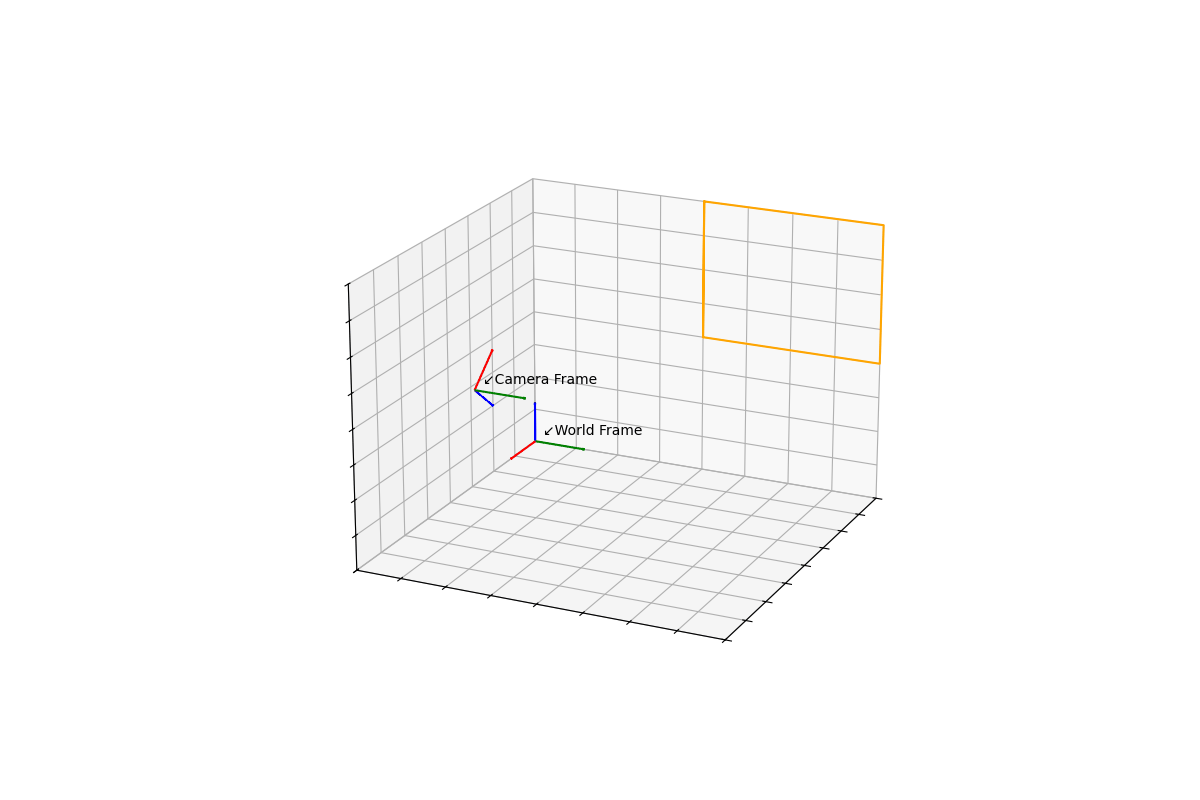

In [8]:
from cameras import apply_transform
from utils import (
    animate_transformation,
    configure_ax,
    plot_frame,
    plot_square,
)

# Vertices per side of the square
N = 2

# Compute vertices corresponding to each side of the square
vertices_wrt_world = np.concatenate(
    [
        np.vstack([np.zeros(N), np.linspace(1, 2, N), np.ones(N)]),
        np.vstack([np.zeros(N), np.ones(N) + 1, np.linspace(1, 2, N)]),
        np.vstack([np.zeros(N), np.linspace(2, 1, N), np.ones(N) + 1]),
        np.vstack([np.zeros(N), np.ones(N), np.linspace(1, 2, N)]),
    ],
    axis=1,
)

# Visualize our rotation!
animate_transformation(
    "transformation.gif",
    vertices_wrt_world,
    camera_from_world_transform,
    apply_transform,
)

import IPython.display

with open("transformation.gif", "rb") as file:
    display(IPython.display.Image(file.read()))

# Uncomment to compare to staff animation
# with open("solution_transformation.gif", "rb") as file:
#     display(IPython.display.Image(file.read()))

## 2. Camera Intrinsics & Vanishing Points

In a pinhole camera, lines that are parallel in 3D rarely remain parallel when projected to the image plane. Instead, parallel lines will meet at a **vanishing point**:

<img alt="vanishing point" src="https://drive.google.com/uc?export=view&id=17aUqBQrws2Cu3a1fJOhZ1AztJB99Hpc7" width="600" />

### 2.1 Homogeneous coordinates (5 points)

Consider a line that is parallel to a world-space direction vector in the set $\{ d \in \mathbb{R}^3 : d^\top d = 1\}$. Show that the image coordinates $v$ of the vanishing point can be be written as $v = KRd$.

*Hints:*
- As per the lecture slides, $K$ is the camera calibration matrix and $R$ is the camera extrinsic rotation.
- As in the diagram above, the further a point on a 3D line is from the camera origin, the closer its projection will be to the line's 2D vanishing point.
- Given a line with direction vector $d$, you can write a point that's infinitely far away from the camera via a limit: $\lim_{\alpha \to \infty} \alpha d$.
- The 3D homogeneous coordinate definition is:
$$
\begin{bmatrix}
    x & y & z & w
\end{bmatrix}^\top
\iff
\begin{bmatrix}
    x/w & y/w & z/w & 1
\end{bmatrix}^\top
$$

**You answer here:** Write your answer in this markdown cell.

Suppose we have a line with direction vector $d$ such that $d \in \mathbb{R}^3: d^\top d = 1$.

Any point on this line can be written as: $$P(α)=X_0+αd$$
where $X_0$ is some point on this line and $\alpha$ is a scalar.

Now, a point $P$ in world coordinates can be projected onto the image plane via the equation mentioned in lecture: $$p \sim K[R|t]P$$
where $K$ is the camera calibration matrix, $R$ the camera extrinsic rotation, and $t$ the camera extrinsic translation.

To obtain the vanishing point $v$, we look at a point that is infinitely far away in the direction $d$. Knowing that translation $t$ has no affect on direction, we see that as $α → ∞$, the projection of $P(α)$ becomes dominated by the term with $d$. That is, $$v = lim_{α → ∞}p(α) = lim_{α → ∞}KR(X_0+αd) = \alpha KRd$$

Since homogeneous coordinates are defined up to a scale, we can divide by α, which shows us that the image coordinates $v$ of the vanishing point can be written as: $$v=KRd$$

### 2.2 Calibration from vanishing points (5 points)

Let $d_0, d_1, \dots$ represent directional vectors for 3D lines in a scene, and $v_0, v_1, \dots$ represent their corresponding vanishing points.

Consider the situtation when these lines are orthogonal:
$$
d_i^\top d_j = 0, \text{for each } i \neq j
$$

Show that:
$$
(K^{-1}v_i)^\top(K^{-1}v_j) = 0, \text{for each } i \neq j
$$

**You answer here:** Write your answer in this markdown cell.

By 2.1, the vanishing point corresponding to a 3D line with direction $d_i$ is given by $$v_i = KRd_i$$
Equivalently, this can be written as:
$$K^{-1}v_i = Rd_i$$

Now, consider two distinct vanishing points $v_i$ and $v_j$ corresponding to 3D lines with orthogonal directions (i.e. $ \; \;i \neq j$, $\; \;d_i^\top d_j = 0$).

The rest follows as...
\begin{align}
(K^{-1}v_i)^{\top}(K^{-1}v_j) &= (Rd_i)^{\top}(Rd_j) \\
(K^{-1}v_i)^{\top}(K^{-1}v_j) &= d_i^{\top} R^{\top}R \;d_j \\
(K^{-1}v_i)^{\top}(K^{-1}v_j) &= d_i^{\top}d_j &\text{since $R$ is orthogonal matrix}\\
(K^{-1}v_i)^{\top}(K^{-1}v_j) &= 0&\text{since $d_i^\top d_j = 0$}\\
\end{align}

### 2.3 Short Response (5 points)

Respond to the following using bullet points:

- In the section above, we eliminated the extrinsic rotation matrix $R$. Why might this simplify camera calibration?

- Assuming square pixels and no skew, how many vanishing points with mutually orthogonal directions do we now need to solve for our camera's focal length and optical center?

- Assuming square pixels and no skew, how many vanishing points with mutually orthogonal directions do we now need to solve for our camera's focal length when the optical center is known?

---

**You answer here:** Write your answer in this markdown cell.

- The elimination of the extrinsic rotation matrix $R$ separates the intrinsic parameters from the extrinsic parameters. Thist simplifies camera calibration as we only need to focus on intrinsic camera parameters (which can solve for using the vanishing points of the image) and not calibrating the camera's orientation to transform from the world to the image plane.
- Assuming square pixels and no skew, we need 3 vanishing points with mutually orthogonal directions to solve for our camera's focal length and optical center as each distinct pair of these vanishing points provides an orthogonality condition (i.e. (a,b), (b,c) and (a,c)), yielding three independent equations to solve for the three unknowns in K: $f$, $p_x$, and $p_y$.
- Assuming square pixels and no skew, we need 2 vanishing points with mutually orthogonal directions to solve for our camera's focal length when the optical center is known as each pair of vanishing points give us 1 equation and we have 1 unknown.

## 3. Intrinsic Calibration

Using the vanishing point math from above, we can solve for a camera matrix $K$!

First, let's load in an image. To make life easier for you, we've hand labeled a set of coordinates on it that we'll use to compute vanishing points.

Image is 1300 x 975


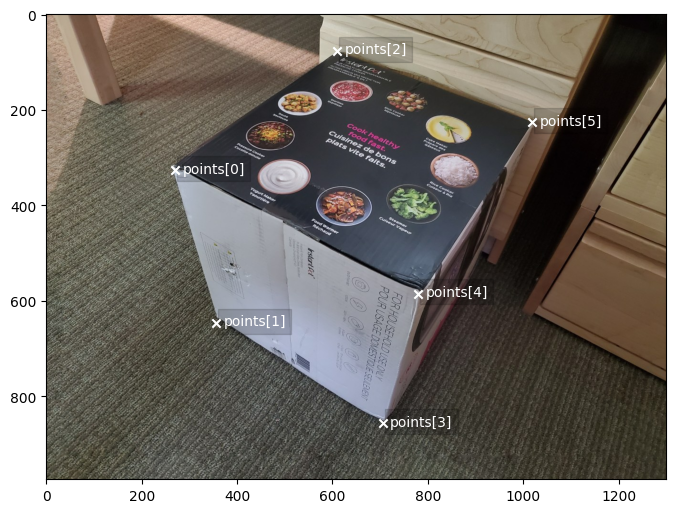

In [9]:
# Load image and annotated points; note that:
# > Our image is a PIL image type; you can convert this to NumPy with `np.asarray(img)`
# > Points are in (x, y) format, which corresponds to (col, row)!
img = Image.open("images/pressure_cooker.jpg")
print(f"Image is {img.width} x {img.height}")
points = np.array(
    [
        [270.0, 327.0],  # [0]
        [356.0, 647.0],  # [1]
        [610.0, 76.0],  # [2]
        [706.0, 857.0],  # [3]
        [780.0, 585.0],  # [4]
        [1019.0, 226.0],  # [5]
    ]
)

# Visualize image & annotated points
fig, ax = plt.subplots(figsize=(8, 10))
ax.imshow(img)
ax.scatter(points[:, 0], points[:, 1], color="white", marker="x")
for i in range(len(points)):
    ax.annotate(
        f"points[{i}]",
        points[i] + np.array([15.0, 5.0]),
        color="white",
        backgroundcolor=(0, 0, 0, 0.15),
        zorder=0.1,
    )

### 3.1 Finding Vanishing Points

In 2D, notice that a vanishing point can be computing by finding the intersection of two lines that we know are parallel in 3D.

To find the vanishing points in the image, implement **`intersection_from_lines()`**.

Then, run the cell below to check that it's working.

In [10]:
from cameras import intersection_from_lines

# Python trivia: the following two assert statements are the same.
# > https://docs.python.org/3/tutorial/controlflow.html#unpacking-argument-lists
# > https://numpy.org/doc/stable/reference/arrays.indexing.html#integer-array-indexing
assert np.allclose(
    intersection_from_lines(points[0], points[1], points[4], points[0],),
    points[0],
)
assert np.allclose(intersection_from_lines(*points[[0, 1, 4, 0]]), points[0])
print("Looks correct!")

Looks correct!


To use the constraint we derived above, we need to find vanishing points that correspond to three orthogonal direction vectors.

Populate `v0_indices`, `v1_indices`, and `v2_indices`, then run the cell below to compute `v`.

You should be able to get an output that looks like this (color ordering does not matter):

![vanishing point reference](https://drive.google.com/uc?export=view&id=14zLgdK-heVHrHfYd0K1OT3yBnaz5hk1S)

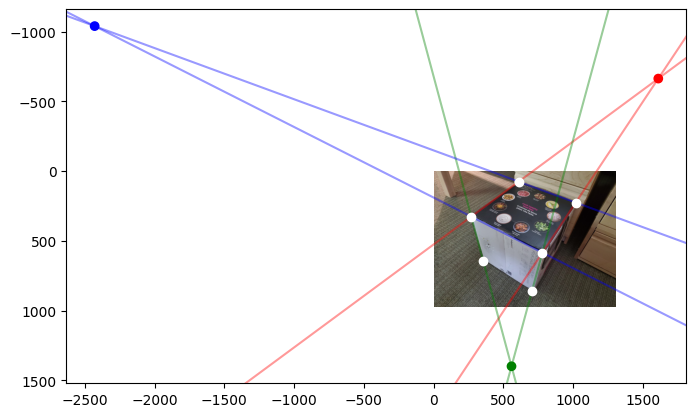

In [11]:
# Select points used to compute each vanishing point
#
# Each `v*_indices` list should contain four integers, corresponding to
# indices into the `points` array; the first two ints define one line and
# the second two define another line.
v0_indices = None
v1_indices = None
v2_indices = None

### YOUR CODE HERE
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

v0_indices = [0, 2, 4, 5]
v1_indices = [0, 1, 3, 4]
v2_indices = [0, 4, 2, 5]

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
### END YOUR CODE

# Validate indices
assert (
    len(v0_indices) == len(v1_indices) == len(v2_indices) == 4
), "Invalid length!"
for i, j, k in zip(v0_indices, v1_indices, v2_indices):
    assert type(i) == type(j) == type(k) == int, "Invalid type!"

# Compute vanishing points
v = np.zeros((3, 2))
v[:, :2] = np.array(
    [
        intersection_from_lines(*points[v0_indices]),
        intersection_from_lines(*points[v1_indices]),
        intersection_from_lines(*points[v2_indices]),
    ]
)
assert v.shape == (3, 2)

# Display image
fig, ax = plt.subplots(figsize=(8, 10))
ax.imshow(img)

# Display annotated points
ax.scatter(points[:, 0], points[:, 1], color="white")

# Visualize vanishing points
colors = ["red", "green", "blue"]
for indices, color in zip((v0_indices, v1_indices, v2_indices), colors):
    ax.axline(*points[indices[:2]], zorder=0.1, c=color, alpha=0.4)
    ax.axline(*points[indices[2:]], zorder=0.1, c=color, alpha=0.4)
ax.scatter(v[:, 0], v[:, 1], c=colors)

pass

### 3.2 Computing Optical Centers

Next, implement **`optical_center_from_vanishing_points()`** to compute the 2D optical center from our vanishing points. Then, run the cell below to compute a set of optical center coordinates from our vanishing points.

*Hint:* Property 3 from [1] may be useful.
> [1] Caprile, B., Torre, V. **Using vanishing points for camera calibration.** *Int J Comput Vision 4, 127–139 (1990)*. https://doi.org/10.1007/BF00127813

Looks correct!


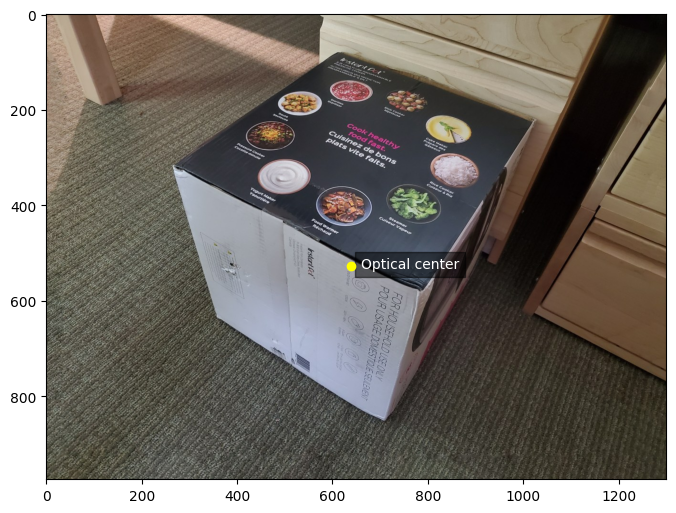

In [12]:
from cameras import optical_center_from_vanishing_points

optical_center = optical_center_from_vanishing_points(v[0], v[1], v[2],)

assert np.allclose(np.mean(optical_center), 583.4127277436276)
assert np.allclose(np.mean(optical_center ** 2), 343524.39942528843)
print("Looks correct!")

# Display image
fig, ax = plt.subplots(figsize=(8, 10))
ax.imshow(img)

# Display optical center
ax.scatter(*optical_center, color="yellow")
ax.annotate(
    "Optical center",
    optical_center + np.array([20, 5]),
    color="white",
    backgroundcolor=(0, 0, 0, 0.5),
    zorder=0.1,
)

pass

### 3.3 Computing Focal Lengths

Consider two vanishing points corresponding to orthogonal directions, and the constraint from above:

$$
(K^{-1}v_0)^\top(K^{-1}v_1) = 0, \text{for each } i \neq j
$$

Derive an expression for computing the focal length when the optical center is known, then implement **`focal_length_from_two_vanishing_points()`**.

When we assume square pixels and no skew, recall that the intrinsic matrix $K$ is:

$$
K = \begin{bmatrix}
    f & 0 & c_x \\
    0 & f & c_y \\
    0 & 0 & 1 \\
\end{bmatrix}
$$

*Hint:* Optional, but this problem maybe be simpler if you factorize $K$ as:

$$
K = \begin{bmatrix}
    1 & 0 & c_x \\
    0 & 1 & c_y \\
    0 & 0 & 1 \\
\end{bmatrix}\begin{bmatrix}
    f & 0 & 0 \\
    0 & f & 0 \\
    0 & 0 & 1 \\
\end{bmatrix}
$$

When working with homogeneous coordinates, note that the lefthand matrix is a simple translation.

In [13]:
from cameras import focal_length_from_two_vanishing_points

# If your implementation is correct, these should all be ~the same
f = focal_length_from_two_vanishing_points(v[0], v[1], optical_center)
print(f"Focal length from v0, v1: {f}")
f = focal_length_from_two_vanishing_points(v[1], v[2], optical_center)
print(f"Focal length from v1, v2: {f}")
f = focal_length_from_two_vanishing_points(v[0], v[2], optical_center)
print(f"Focal length from v0, v2: {f}")

Focal length from v0, v1: 1056.992519708474
Focal length from v1, v2: 1056.9925197084738
Focal length from v0, v2: 1056.992519708474


### 3.4 Comparison to EXIF data

To validate our focal length computation, one smoke test we can run is compare it to parameters supplied by the camera manufacturer.

In JPEG images, these parameters and other metadata are sometimes stored using [EXIF](https://en.wikipedia.org/wiki/Exif) tags that are written when the photo is taken. Run the cell below to read & print some of this using the Python Imaging Library!

In [14]:
from PIL.ExifTags import TAGS

# Grab EXIF data
exif = {TAGS[key]: value for key, value in img._getexif().items()}

# Print subset of keys
print(f"EXIF data for {img.filename}\n=====")
for key in (
    "DateTimeOriginal",
    "FocalLength",
    "GPSInfo",
    "Make",
    "Model",
):
    print(key.ljust(25), exif[key])

EXIF data for images/pressure_cooker.jpg
=====
DateTimeOriginal          2020:11:06 01:02:20
FocalLength               4.3
GPSInfo                   {1: 'N', 2: (37.0, 25.0, 29.903), 3: 'W', 4: (122.0, 9.0, 34.294), 5: b'\x00', 6: 0.0}
Make                      samsung
Model                     SM-G970U


From above, we see that the focal length of our camera system is **`4.3mm`**.

Focal lengths are typically in millimeters, but all of the coordinates we've worked with thus far have been in pixel-space. Thus, we first need to convert our focal length from pixels to millimeters.

Try to visualize this conversion, then implement **`physical_focal_length_from_calibration()`**.

In [15]:
from cameras import physical_focal_length_from_calibration

# Length across sensor diagonal for SM-G970U (Galaxy S10e)
# > https://en.wikipedia.org/wiki/Samsung_CMOS
sensor_diagonal_mm = 7.06

# Length across image diagonal
image_diagonal_pixels = np.sqrt(img.width ** 2 + img.height ** 2)

f_mm = physical_focal_length_from_calibration(
    f, sensor_diagonal_mm, image_diagonal_pixels,
)
print(f"Computed focal length:".ljust(30), f_mm)

error = np.abs(f_mm - 4.3) / 4.3
print("Calibration vs spec error:".ljust(30), f"{error * 100:.2f}%")
assert 0.06 < error < 0.07

Computed focal length:         4.592225962548816
Calibration vs spec error:     6.80%


### 3.5 Analysis (5 points)

If everything went smoothly, your computed focal length should only deviate from the manufacturer spec by ~6.8%.

Aside from manufacturing tolerances, name two or more other possible causes for this error, then discuss the limitations of this calibration method.

**You answer here:** Write your answer in this markdown cell.

Two other possible causes for this error:
1. Lens Distortion: Lens can introduce radial or tangential distortions that can shift the apparent positions of vanishing points, which can affect focal length estimation.
2. Vanishing Point Detection: Vanishing points are determined by projecting parallel lines in 3D space into the image plane, which is subject to noise in image measurements, imperfect parallel lines in the real world, limited resolution, etc.

Limitations of this calibration:
As mentioned earlier, there are a lot of geometric assumptions and extraneous factors that limit the accuracy of the calibration (i.e. perfect pinhole camera model, image noise/clarity, distortion, etc). These inaccuracies could be reduced to some extent by using more appropriate cameras and better image quality, but ultimately, there is likely to be a limit.


## 4 Extra Credit

You can choose to attempt both, either, or neither! Each will count for up to 0.5% of your grade (1% total).

**a) Projection**

Generate a set of geometric shapes: cylinders, cubes, spheres, etc. Then, use your calibrated intrinsics to render them into the scene with correct perspective.

These can be simple wireframe representations (eg `plt.plot()`); no need for fancy graphics.


**b) Extrinsinc Calibration** (*Hard, possibly requires a lot of Google*)

Given that our box is 340mm (L) x 310mm (W) x 320mm (H), compute a 3D transformation (position, orientation) between the center of the box and the camera. In your submission, describe your approach and verify it by using both your calibrated extrinsics and intrinsics to overlay the image with a wireframe version of the box.